# Inter-Canister Call Overhead

What
- Calculate overhead for using Inter-Canister Call (ICC) on the Internet Computer

Why
- Helps to decide on single- vs multi- canister architecture

How
- Call a chain of canisters with various `depth` in a loop
  - The last canister in the chain does a no-op operation, eg. 1+1
  - Measure `outer_time` –- time outside of `dfx` call
  - Measure `inner_time` –- time inside the [top level canister](./src/canister_0/main.mo)
  - Measure `iterations` of the loop
  - Calculate `time_diff` –- inner/outer time difference
  - Calculate `time_per_call_ms` -- time per ICC
    - `time_per_call = inner_time / (iterations * depth)`
  - Calculate `call_rate` -- ICC rate per sec
- Assuming finalization rate at 1 ops/s it does not make sense to run experiment with
  - `inner_time < 10 sec`, error >10%
  - `inner_time > 20 sec`, too slow

## Summary

- Maximal inter-canister call depth: 20
- Median time per inter-canister call: ~2.36 ms
- Median inter-canister call rate: ~423 calls/s
- Median inner/outer time difference: ~5.02 sec
  - `time_diff` is constant accros `inner_time` values

![image](./image/time_per_call_ms_hist.png)
![image](./image/time_per_call_ms_vs_depth.png)
![image](./image/call_rate_hist.png)
![image](./image/call_rate_vs_depth.png)
![image](./image/time_diff_hist.png)
![image](./image/inner_outer_time_diff.png)

## Notes

- More numbers and charts at [Analysis ipython notebook](./analysis.ipynb)
- Run experiment with [run_exp.sh](./run_exp.sh), adjust input values before the run

### Issues

- Sometimes `dfx` hands for way too long, use `gtimeout Xs` to cut execution after a timeout

## Links

- [Make inter-canister calls](https://internetcomputer.org/docs/current/developer-docs/build/backend/intercanister-calls/)
- [Analysis ipython notebook](./analysis.ipynb)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_theme(color_codes=True); sns.set(rc={'figure.figsize':(7, 5)})
import matplotlib.pyplot as plt

# Read input data.
df = pd.read_csv('./data/all_2.csv')

# Cleanup.
df.drop(columns=['run'], inplace=True)  # Drop 'run' column.
df.drop_duplicates(inplace=True)        # Drop duplicates.
df.dropna(inplace=True)
df = df[df.depth>0]
df = df[df.iterations>0]

# Calculate new columns.
df['time_diff'] = df.outer_time - df.inner_time
df['time_per_call_ms'] = 1000 * df.inner_time / (df.depth * df.iterations)
df['call_rate'] = 1000 / df.time_per_call_ms

# Drop outliers.
# df = df[df.method == 'compute_iterations']
# df = df[df.time_diff > 0]
# df = df[df.time_diff < 20]
# df = df[df.inner_time <= 20]
# df = df[df.inner_time >= 10]
# df = df[(df.depth==4)|(df.depth==8)|(df.depth==12)|(df.depth==16)|(df.depth==20)]
# df = df[df.time_per_call_ms > 0.5]
# df = df[df.call_rate < 1000]
df.reset_index(drop=True, inplace=True)

df.tail()

,method,depth,iterations,inner_time,outer_time,time_diff,time_per_call_ms,call_rate
1204,compute_iterations,20,395,18.0,22.171924,4.171924,2.278481,438.888889
1205,compute_iterations,20,336,16.0,21.179361,5.179361,2.380952,420.000000
1206,compute_iterations,20,297,14.0,18.452425,4.452425,2.356902,424.285714
1207,compute_iterations,20,257,12.0,16.357112,4.357112,2.334630,428.333333
1208,compute_iterations,20,218,10.0,14.835461,4.835461,2.293578,436.000000


## Inter-canister call time and call rate

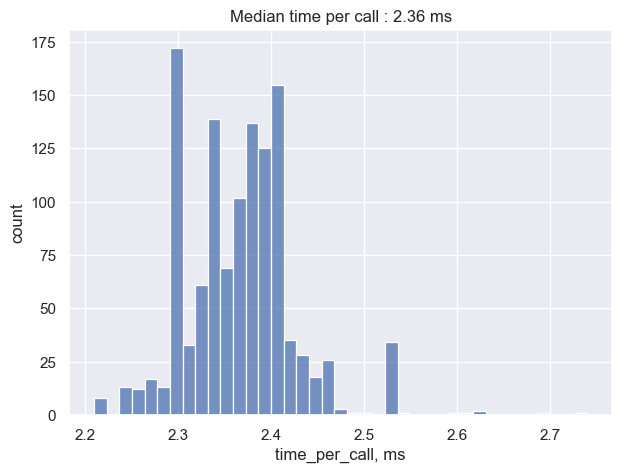

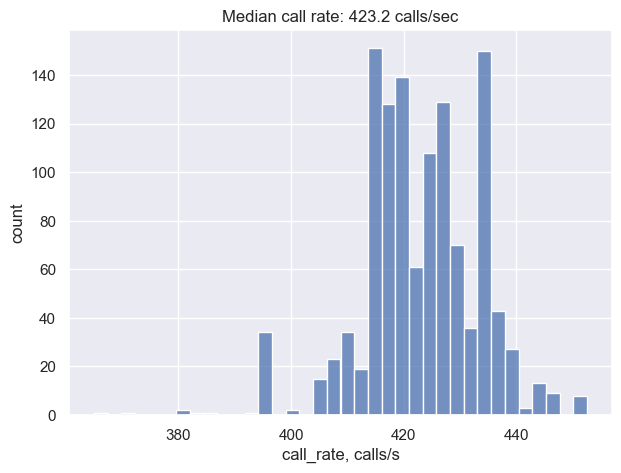

In [2]:
time_per_call_ms = f'Median time per call : {df.time_per_call_ms.median().round(2)} ms'
call_rate = f'Median call rate: {df.call_rate.median().round(1)} calls/sec'

ax = sns.histplot(x='time_per_call_ms', data=df)
ax.set_title(time_per_call_ms)
ax.set(xlabel='time_per_call, ms', ylabel='count')
plt.savefig('./image/time_per_call_ms_hist.png')
plt.show(ax)

ax = sns.histplot(x='call_rate', data=df)
ax.set_title(call_rate)
ax.set(xlabel='call_rate, calls/s', ylabel='count')
plt.savefig('./image/call_rate_hist.png')
plt.show(ax)

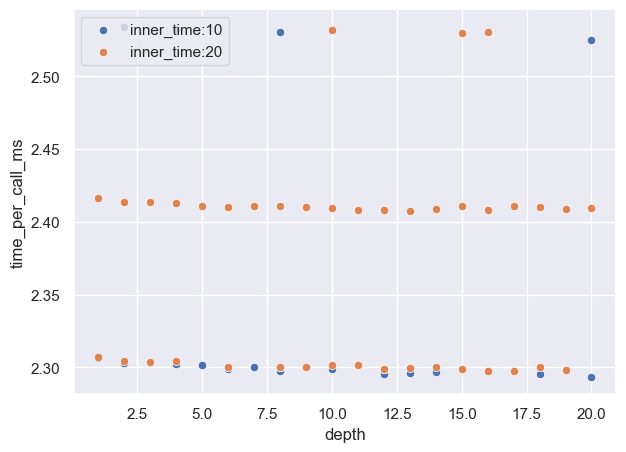

In [3]:
for time in [10, 20]:
    ax = sns.scatterplot(x='depth', y='time_per_call_ms', data=df[df.inner_time==time], label=f'inner_time:{time}')
    ax.legend()
plt.savefig('./image/time_per_call_ms_vs_depth.png')

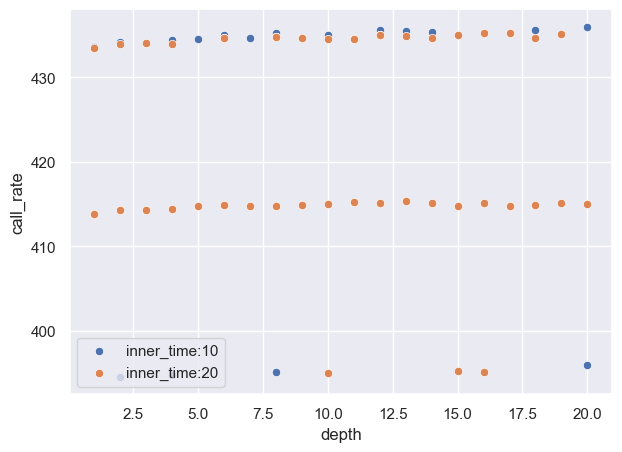

In [4]:
for time in [10, 20]:
    ax = sns.scatterplot(x='depth', y='call_rate', data=df[df.inner_time==time], label=f'inner_time:{time}')
    ax.legend()
plt.savefig('./image/call_rate_vs_depth.png')

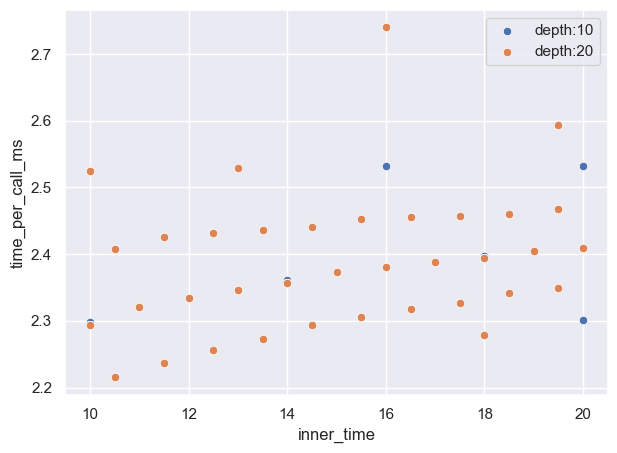

In [5]:
for depth in [10, 20]:
    ax = sns.scatterplot(x='inner_time', y='time_per_call_ms', data=df[df.depth==depth], label=f'depth:{depth}')
    ax.legend()

## Inner/outer time difference

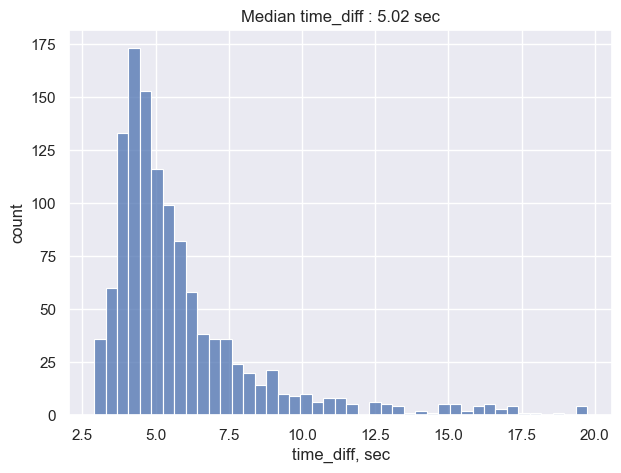

In [6]:
time_diff = f'Median time_diff : {df.time_diff.median().round(2)} sec'

ax = sns.histplot(x='time_diff', data=df)
ax.set_title(time_diff)
ax.set(xlabel='time_diff, sec', ylabel='count')
plt.savefig('./image/time_diff_hist.png')

- `time_diff` is constant accross `inner_time` values

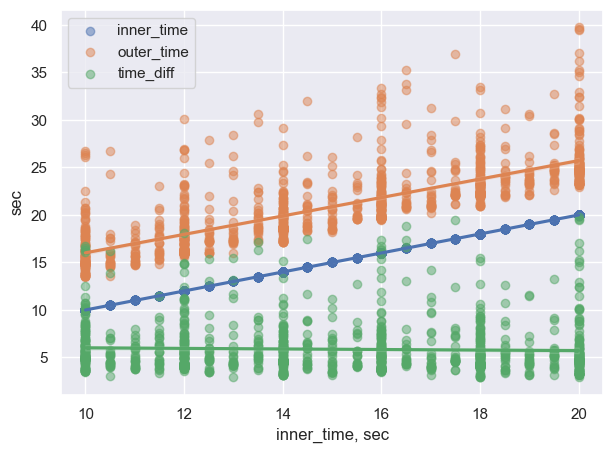

In [7]:
for label in ['inner_time', 'outer_time', 'time_diff']:
    ax = sns.regplot(x='inner_time', y=label, data=df, label=label, scatter_kws={'alpha':0.5})
    ax.legend()
    ax.set(xlabel='inner_time, sec', ylabel='sec')
plt.savefig('./image/inner_outer_time_diff.png')

## Input Data Distribution

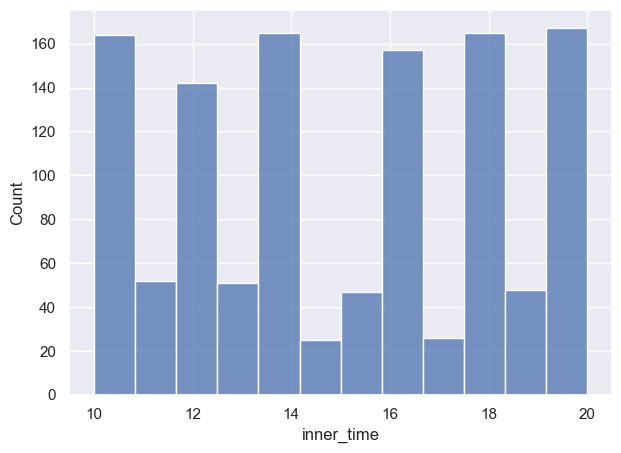

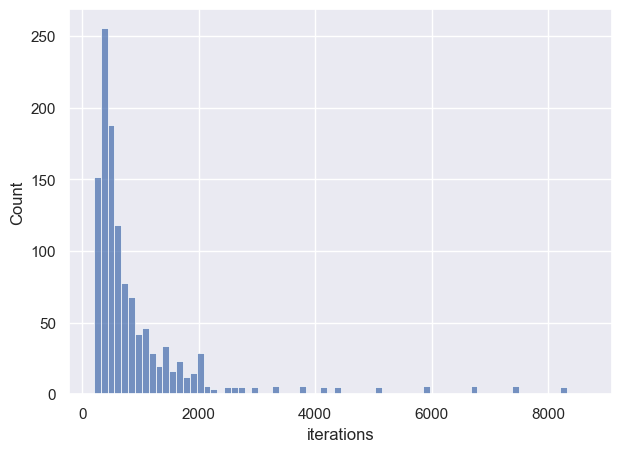

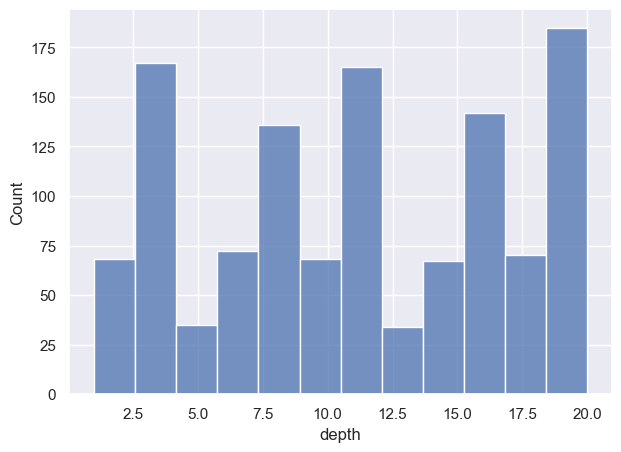

In [8]:
plt.show(sns.histplot(x='inner_time', data=df))
plt.show(sns.histplot(x='iterations', data=df))
plt.show(sns.histplot(x='depth', data=df))

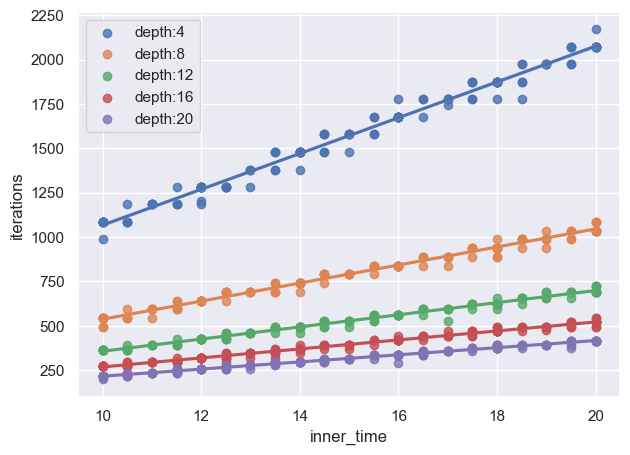

In [9]:
for depth in [4, 8, 12, 16, 20]:
  ax = sns.regplot(x='inner_time', y='iterations', data=df[df.depth==depth], label=f'depth:{depth}')
  ax.legend()

## Output Data Distribution

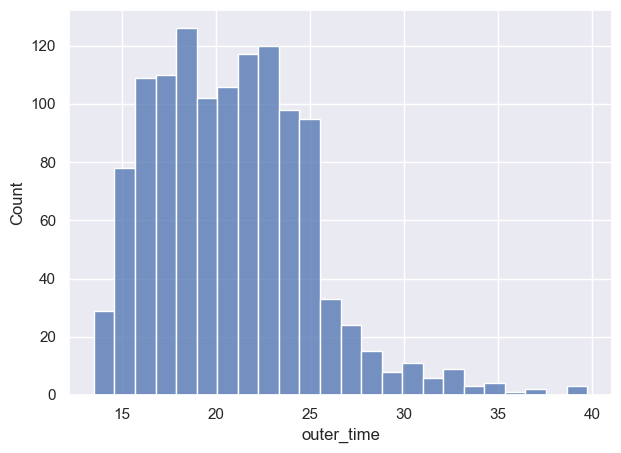

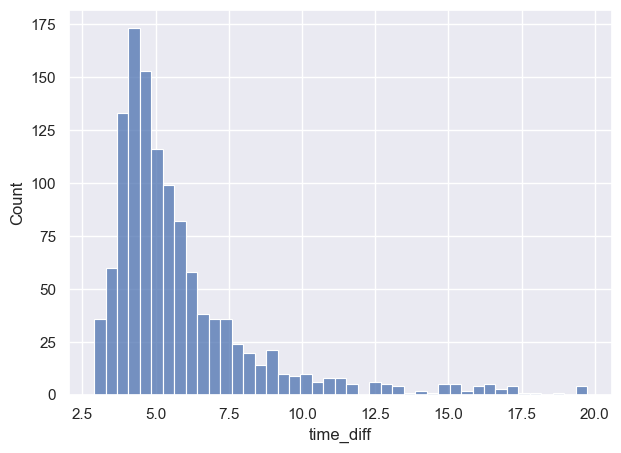

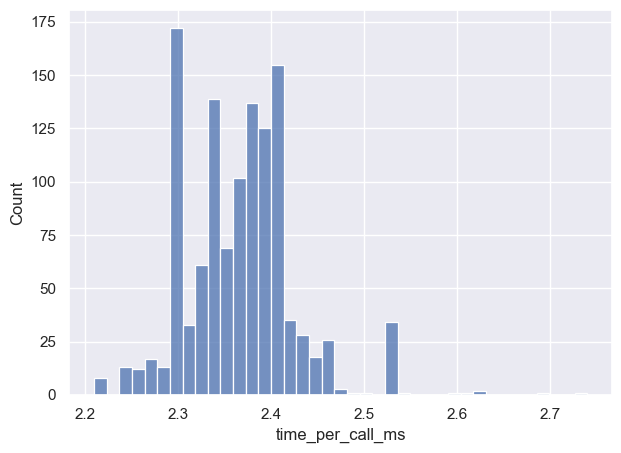

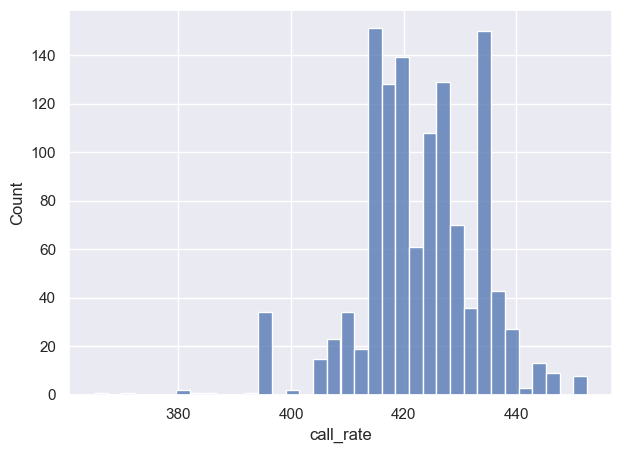

In [10]:
plt.show(sns.histplot(x='outer_time', data=df))
plt.show(sns.histplot(x='time_diff', data=df))
plt.show(sns.histplot(x='time_per_call_ms', data=df))
plt.show(sns.histplot(x='call_rate', data=df))

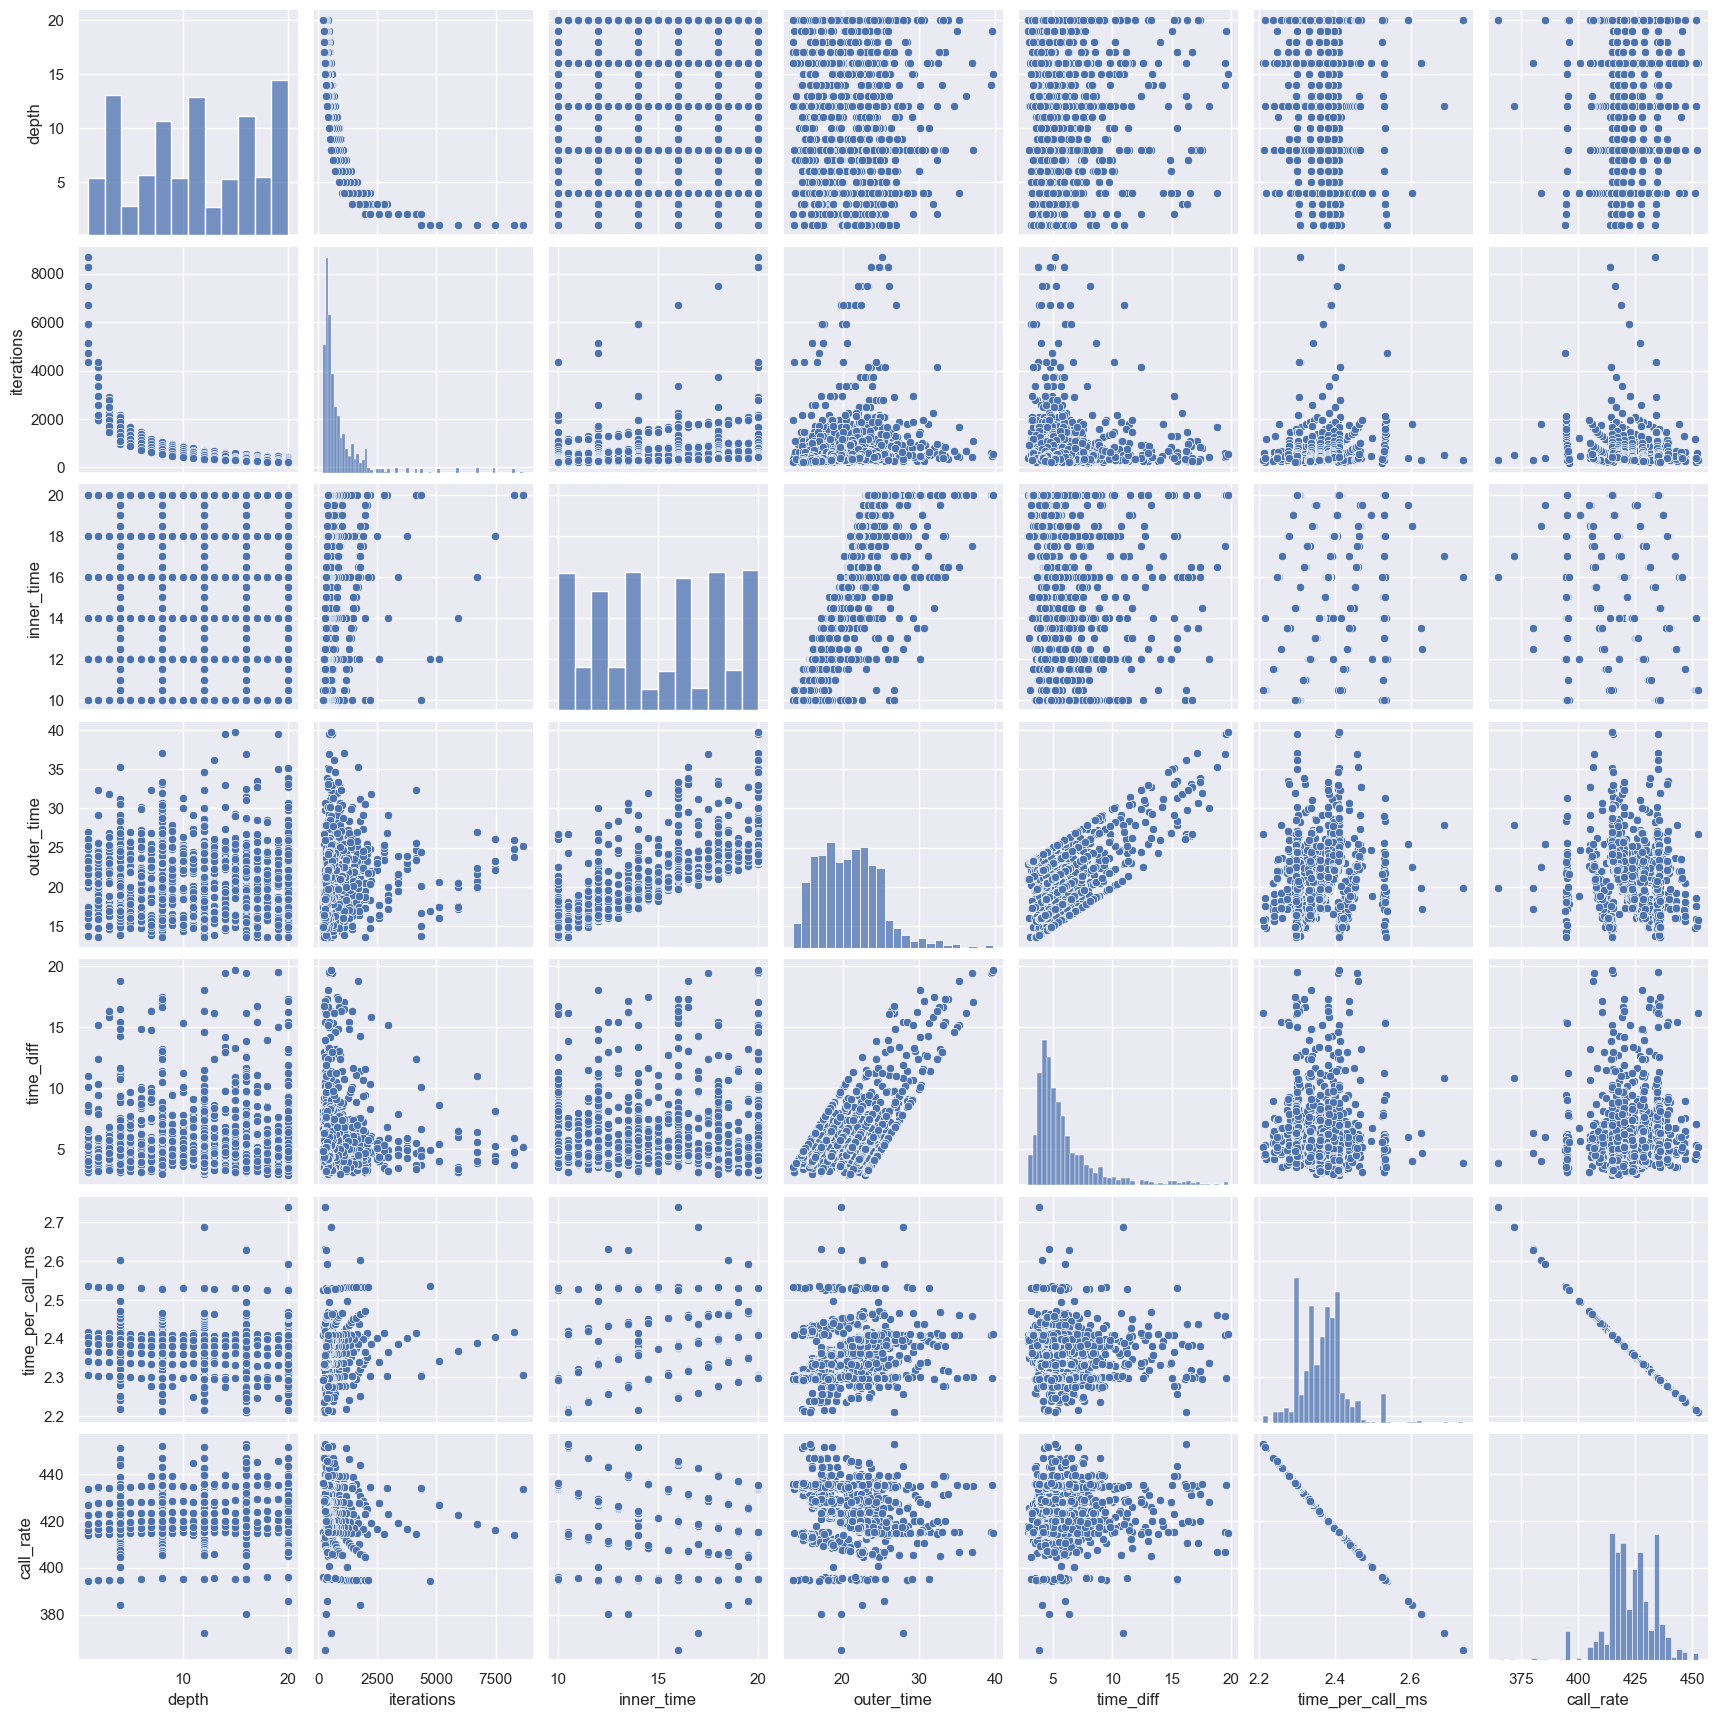

In [11]:
sns.pairplot(df)